In [1]:
# Post-processing with conformal prediction, using the logits tracked from training
import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# analyze the dataframes for training and validation from each epoch
# we start by grabbing the dataframes

#csv_folder = "../logs/Baseline_r2plus1d_all/csvs/"
csv_folder = "../logs/R18_cifar/round1/csvs"
train_csvs = glob.glob(f"{csv_folder}/train_*.csv")
val_csvs = glob.glob(f"{csv_folder}/val_*.csv")

N_CLASSES=10
ALPHA=0.10

def extract_file_index(filename):
    # Use regular expression to find numerical part in the filename
    match = re.findall(r'\d+', filename)[-3]
    if match:
        numerical_part = int(match)
        return numerical_part
    else:
        # Return a default value or handle the case where no numerical part is found
        return None

# sort ascending by the numerical suffix for each file with regex search
def sort_by_epoch(files_list):
    indices = []
    for i in range(len(files_list)):
        index = extract_file_index(files_list[i])
        indices.append(index)
    new_array = [None] * len(indices)
    for j in range(len(indices)):
        new_array[indices[j]] = files_list[j]
    return new_array

print(sort_by_epoch(val_csvs))
#print(train_csvs)

['../logs/R18_cifar/round1/csvs/val_0_0.72.csv', '../logs/R18_cifar/round1/csvs/val_1_0.74.csv', '../logs/R18_cifar/round1/csvs/val_2_0.75.csv', '../logs/R18_cifar/round1/csvs/val_3_0.75.csv', '../logs/R18_cifar/round1/csvs/val_4_0.76.csv', '../logs/R18_cifar/round1/csvs/val_5_0.76.csv', '../logs/R18_cifar/round1/csvs/val_6_0.76.csv', '../logs/R18_cifar/round1/csvs/val_7_0.76.csv', '../logs/R18_cifar/round1/csvs/val_8_0.76.csv', '../logs/R18_cifar/round1/csvs/val_9_0.76.csv']


In [3]:
train_df = [pd.read_csv(x) for x in sort_by_epoch(train_csvs)]
val_df = [pd.read_csv(x) for x in sort_by_epoch(val_csvs)]

# since train_df is ordered randomly, sort each dataframe by the filename
train_df = [df.sort_values(by=['filename']).reset_index() for df in train_df]
val_df = [df.sort_values(by=['filename']).reset_index() for df in val_df]

In [4]:
train_df[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4,outputs_5,outputs_6,outputs_7,outputs_8,outputs_9
0,138887,138887,0,6,-2.055141,-0.997491,2.321488,2.662184,0.674063,1.089346,4.410739,-1.187187,-0.762652,-1.998830
1,112797,112797,1,6,-1.267461,-1.003492,0.224644,2.594508,1.428692,1.519615,3.732602,-0.582827,-0.766820,-2.783251
2,111324,111324,2,6,-1.896580,-2.024358,0.223772,2.991205,0.710831,3.020461,2.378181,2.209347,-2.099962,-2.364418
3,27210,27210,3,6,-1.874459,-1.927674,0.812546,2.580495,1.144187,1.516077,3.327151,0.957737,-1.517279,-1.086343
4,102178,102178,4,9,0.043180,0.537062,0.190971,-0.281621,-0.345787,-2.103682,-0.185933,-0.210845,1.513715,2.533091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,82725,82725,159995,2,2.030861,-1.010509,5.503224,0.128208,2.211293,-0.680888,0.959767,0.743401,-0.276654,-3.725714
159996,17596,17596,159996,8,1.351278,0.433287,-0.816691,-1.066306,-1.446493,-1.611002,-3.443231,0.102890,2.296309,3.933851
159997,36040,36040,159997,8,3.657224,1.952378,-1.343915,-0.628178,-0.731699,-2.051197,-3.962487,0.834075,2.048017,2.443125
159998,48897,48897,159998,8,0.522075,0.105437,0.570110,0.267854,-0.495493,0.096801,-0.786295,-1.624779,4.292795,0.305442


In [5]:
def df_to_logits(df, sm=False):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    if sm:
        logits = softmax(logits, axis=1)
    return logits

train_probs = [df_to_logits(x, False) for x in train_df]
val_probs = [df_to_logits(x, False) for x in val_df]

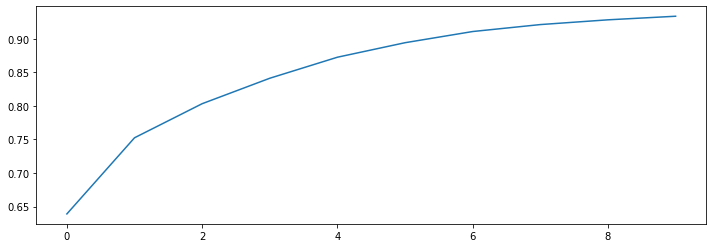

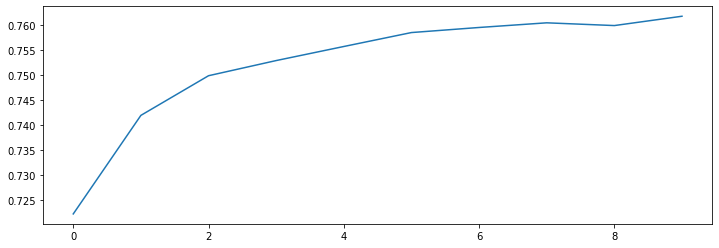

[[10708   578   694   382   381   172   204   313  1872   640]
 [  625 11689   218   241   242   125   180   204   688  1732]
 [ 1122   260  8461  1061  1672   878  1459   675   437   167]
 [  468   252   925  8060   960  2652  1267   581   382   389]
 [  379    93  1141   811  9644   620  1372  1413   375   164]
 [  248   176   910  2652  1055  8914   603   966   185   191]
 [  214   138   966   864  1088   432 11934   190   144   110]
 [  386   234   601   837  1497   979   324 10496   283   455]
 [ 1845   728   285   262   369   155   172   173 11135   864]
 [  697  1616   159   269   308   152   166   320   874 11351]]
[[12380   308   491   285   218   113   158   222  1320   449]
 [  383 13290   149   172    86    71   101   114   462  1116]
 [  837   145 10885   761  1122   540  1052   458   293    99]
 [  360   159   750 10041   624  2226   854   438   244   240]
 [  272    45   915   553 11587   482   928   907   229    94]
 [  153   101   662  2272   693 10678   414   674   14

In [6]:
# show the trend-line of prediction F1 score for training and test set
def plot_f1_over_time(epoch_0_dataframe, all_probs):
    # epoch_0_dataframe is the dataframe results at epoch 0
    # probs_progression is the list of probabilities for each epoch
    gt = np.array(epoch_0_dataframe['y'])
    preds = [np.argmax(p, axis=1) for p in all_probs]
    f1s = [f1_score(gt, p, average='macro') for p in preds]
    fig, ax = plt.subplots(figsize=(12,4))
    t = np.arange(len(preds))
    ax.plot(t, f1s)
    plt.show()

def cf_over_time(epoch_0_dataframe, all_probs):
    gt = np.array(epoch_0_dataframe['y'])
    preds = [np.argmax(p, axis=1) for p in all_probs]
    [print(confusion_matrix(gt, p)) for p in preds]

plot_f1_over_time(train_df[0], train_probs)
plot_f1_over_time(val_df[0], val_probs)
cf_over_time(train_df[0], train_probs)
cf_over_time(val_df[0], val_probs)

Epoch 0, F1 score = 0.7223255958144849


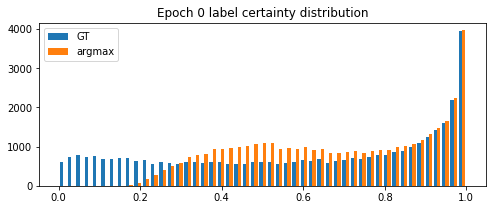

Epoch 1, F1 score = 0.7419608342294501


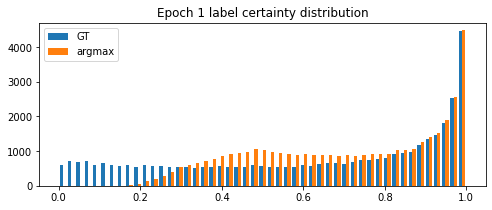

Epoch 2, F1 score = 0.7498592774166202


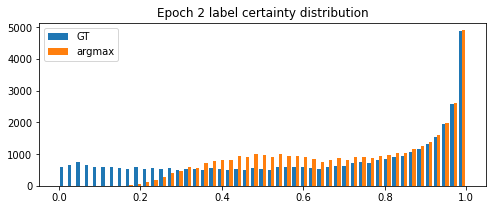

Epoch 3, F1 score = 0.7528786863519157


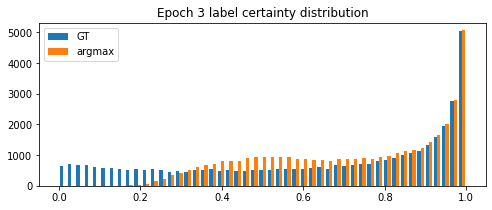

Epoch 4, F1 score = 0.7556818362421713


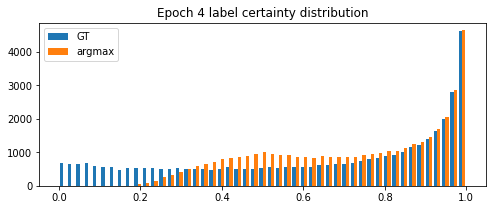

Epoch 5, F1 score = 0.7584591404300353


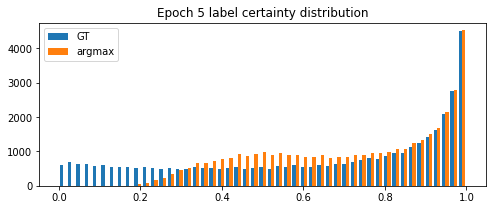

Epoch 6, F1 score = 0.7594702461947226


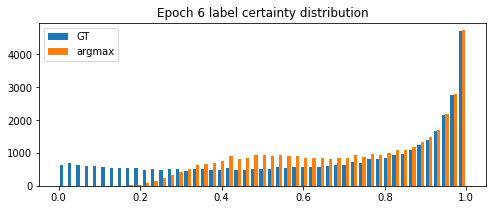

Epoch 7, F1 score = 0.7603978717933957


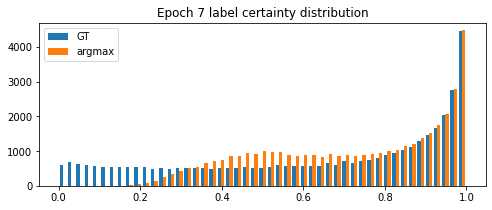

Epoch 8, F1 score = 0.7598519140737768


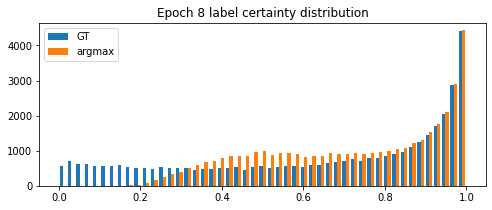

Epoch 9, F1 score = 0.7617089176514538


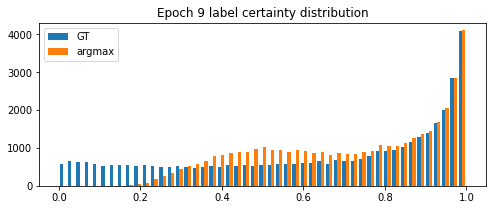

In [7]:
# we are setting up the validation set as the calibration set, to be more kosher, you should use an unseen subset of training
# check the certainty distribution of validation set
def certainty_hist(y, preds, epoch=-1):
    # y is (N,) integer array of C classes
    # preds is (N, C) array
    pred_classes = np.argmax(preds,axis=1)
    pred_confidence = np.max(preds,axis=1)
    gt_confidence = preds[range(len(y)),y]
    print(f"Epoch {epoch}, F1 score = {f1_score(y, pred_classes, average='macro')}")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.hist([gt_confidence, pred_confidence], bins=49)
    plt.legend(['GT', 'argmax'])
    plt.title(f"Epoch {i} label certainty distribution")
    plt.show()

# first check the validation set for naive softmaxing
for i in range(len(val_df)):
    y = val_df[i]['y']
    preds = softmax(val_probs[i], axis=1)
    certainty_hist(y, preds, i)

In [8]:
# run conformal prediction on a select epoch to return the prediction sets
def LABEL(y, preds, alpha=0.1, verbose=False):
    # y is (N,) integer array of C classes
    # preds is (N, C) array of confidences
    
    desired_accuracy = 1 - alpha
    N = len(y)
    pred_classes = np.argmax(preds,axis=1)
    pred_confidence = np.max(preds,axis=1)
    gt_confidence = preds[range(N),y]
    # calculate the conformal score s as a general imprecise uncertainty measure (can be many ways, this is a simple way)
    s = 1 - gt_confidence
    # find the q level
    adj_q_level = np.ceil((N+1) * desired_accuracy)/N
    #adj_q_level = desired_accuracy
    qhat = np.quantile(s, adj_q_level)
    # create sets based on the q-level
    cutoff = 1 - qhat
    conformal_set = []
    for i in range(N):
        conformal_set.append(preds[i] >= cutoff)
        
    if verbose:
        print(f"adjusted q-level {adj_q_level}, q-hat {qhat}")
    return np.array(conformal_set)

In [9]:
def APS(cal_labels, cal_smx, alpha=0.1, verbose=False):
    # Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
    N = cal_smx.shape[0]
    
    # argsort returns the indices of the sort
    cal_pi = cal_smx.argsort(1)[:, ::-1]
    
    # take_along_axis returns results of the sort, then cumulative sum
    cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
    
    # this is some 5head stuff I dont get
    # but it returns "the cumulative sum by the time I get to class X"
    cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(N), cal_labels]
    
    # Get the score quantile
    adj_q_level = np.ceil((N + 1) * (1 - alpha)) / N
    qhat = np.quantile(cal_scores, adj_q_level, interpolation="higher")
    if verbose:
        print(f"adjusted q-level {adj_q_level}, q-hat {qhat}")
    
    # Deploy (output=list of length n, each element is tensor of classes)
    cal_pi = cal_smx.argsort(1)[:, ::-1]
    
    cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
    
    prediction_sets = np.take_along_axis(cal_srt <= qhat, cal_pi.argsort(axis=1), axis=1)
    return prediction_sets
    

In [10]:
y = val_df[2]['y']
preds = softmax(val_probs[2], axis=1)
cs = APS(y, preds, ALPHA, verbose=True)
print(cs[:15])

In [12]:
# test the coverage of conformal prediction
def coverage_test(y, preds_cover):
    # y is (N,) integer array of C classes
    # preds_cover is (N, C) boolean array indicating the cover
    correct = []
    for i in range(len(y)):
        if preds_cover[i, y[i]]:
            correct.append(True)
        else:
            correct.append(False)
    return np.array(correct)

correctness = coverage_test(y, cs) 
print(np.sum(correctness)/len(y)) # should be around 0.9

0.90005


In [13]:
def class_conditional_coverage_test(y, preds_cover, num_classes=4):
    # returns an accuracy for each class
    class_cond_acc = np.zeros(num_classes)
    for c in range(num_classes):
        mask = y == c
        preds_c = preds_cover[mask]
        N_c = len(preds_c)
        correct = 0
        for i in range(N_c):
            if preds_c[i,c]:
                correct += 1
        class_cond_acc[c] = correct/N_c
    return class_cond_acc
correctness = class_conditional_coverage_test(y, cs, N_CLASSES) 
correctness

array([0.92455621, 0.79807692, 0.92069328, 0.9601378 , 0.94633902,
       0.94780488, 0.92933673, 0.83700102, 0.89257228, 0.8444227 ])

In [14]:
# check the cardinality of the conformal prediction
def cp_cardinality(y, preds_cover, preds, n_classes=4):
    cardinality = np.sum(preds_cover, axis=1)
    correct = coverage_test(y, preds_cover)
    card_correct = cardinality[correct]
    card_incorrect = cardinality[~correct]
    
    n_bins = n_classes + 1
    c_amount, c_bins = np.histogram(card_correct, bins=np.arange(n_bins)+0.5)
    n_amount, _ = np.histogram(card_incorrect, bins=np.arange(n_bins)+0.5)
    card_acc = c_amount / (c_amount + n_amount + 1e-9)
    print(f"Number of correct preds of size [1..N_classes]: {c_amount}")
    print(f"Number of incorrect preds of size [1..N_classes]: {n_amount}")
    print(f"Accuracy of preds of size [1..N_classes]: {card_acc}")

    top1_accs = []
    pred_classes = np.argmax(preds, axis=1)
    for i in np.arange(n_classes)+1:
        gt_w_card_i = y[cardinality==i]
        pred_w_card_i = pred_classes[cardinality==i]
        acc_w_card_i = np.sum(gt_w_card_i == pred_w_card_i) / (len(gt_w_card_i) + 1e-9)
        top1_accs.append(acc_w_card_i)
    print(f"Top-1 acc of preds of size [1..N_classes]: {top1_accs}")
    return np.mean(cardinality)

cp_cardinality(y, cs, preds, n_classes=N_CLASSES)

Number of correct preds of size [1..N_classes]: [3636 3506 4308 4983 5448 5021 4813 3567  720    0]
Number of incorrect preds of size [1..N_classes]: [197  35  55  53  57  47  65  61  17   0]
Accuracy of preds of size [1..N_classes]: [0.94860423 0.99011579 0.98739399 0.98947577 0.98964578 0.99072612
 0.98667487 0.98318633 0.97693351 0.        ]
Top-1 acc of preds of size [1..N_classes]: [0.9486042264542268, 0.9262920079071092, 0.8478111391242612, 0.7714455917393225, 0.7133514986374725, 0.6602209944750078, 0.5744157441573238, 0.48401323042985556, 0.38398914518265403, 0.0]


4.2971

In [15]:
# run conformal prediction on each epoch
f1s = []
coverages = []
cardinalities = []
for i in range(len(val_df)):
    y = np.array(val_df[i]['y'])
    preds = softmax(val_probs[i], axis=1)
    pred_classes = np.argmax(preds,axis=1)
    print(f"Epoch {i}")
    print(f"Original classifier F1 = {f1_score(y, pred_classes, average='macro')}")
    f1s.append(f1_score(y, pred_classes, average='macro'))
    
    #cs = LABEL(y, preds, ALPHA)
    cs = APS(y, preds, ALPHA)
    
    correctness = coverage_test(y, cs)
    print(f"Conformal coverage accuracy = {np.sum(correctness)/len(y)}")
    coverages.append(np.sum(correctness)/len(y))
    correctness = class_conditional_coverage_test(y, cs, num_classes=N_CLASSES)
    print(f"Class-conditional coverage accuracy = {correctness}")
    avg_card = cp_cardinality(y, cs, preds, n_classes=N_CLASSES)
    cardinalities.append(avg_card)

Epoch 0
Original classifier F1 = 0.7223255958144849
Conformal coverage accuracy = 0.90005
Class-conditional coverage accuracy = [0.92578895 0.75887574 0.93040966 0.96530512 0.93931795 0.93243902
 0.93545918 0.86821904 0.86764706 0.87891389]
Number of correct preds of size [1..N_classes]: [3305 3394 4295 5102 5527 4908 5044 3735  692    0]
Number of incorrect preds of size [1..N_classes]: [221  67  72  61  68  58  79  71  11   0]
Accuracy of preds of size [1..N_classes]: [0.93732275 0.98064143 0.98351271 0.98818516 0.98784629 0.98832058
 0.98457935 0.98134524 0.98435277 0.        ]
Top-1 acc of preds of size [1..N_classes]: [0.9373227453202106, 0.8893383415195351, 0.8273414243185647, 0.7420104590353007, 0.6807864164431312, 0.6379379782519858, 0.55358188561379, 0.4700472937465922, 0.3271692745372302, 0.0]
Epoch 1
Original classifier F1 = 0.7419608342294501
Conformal coverage accuracy = 0.90005
Class-conditional coverage accuracy = [0.91444773 0.74408284 0.93277311 0.96579724 0.95160481 0

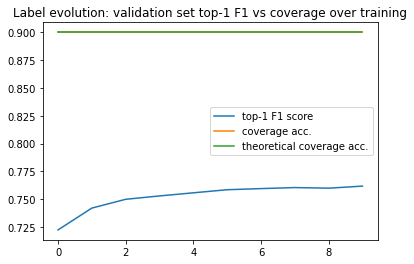

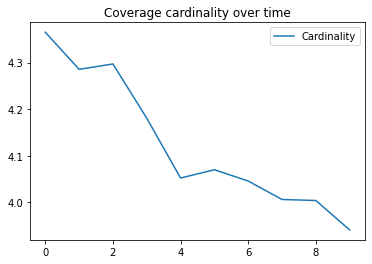

In [16]:
plt.plot(range(len(val_df)), f1s)
plt.plot(range(len(val_df)), coverages)
plt.plot(range(len(val_df)), np.full(shape=len(val_df), fill_value=0.90))
plt.title('Label evolution: validation set top-1 F1 vs coverage over training')
plt.legend(['top-1 F1 score', 'coverage acc.', 'theoretical coverage acc.'])
plt.show()

plt.figure()
plt.plot(range(len(val_df)), cardinalities)
plt.title('Coverage cardinality over time')
plt.legend(['Cardinality'])
plt.show()